#### Data Exploratory

#### Data Cleaning & Transformation Functions

Emoticons and Emoji data dictionary

In [9]:
import re

from emo_unicode import EMOTICONS_EMO as EMOTICONS , UNICODE_EMOJI as UNICODE_EMO

In [10]:
def convert_emojis(comment):
    for emot in UNICODE_EMO:
        # comment = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), comment)
        # comment = comment.replace(emot, UNICODE_EMO[emot][1:-1])
        pattern = re.escape(emot)
        comment = re.sub(pattern, ' '+UNICODE_EMO[emot][1:-1], comment)
    return str(re.sub('_', ' ', comment))

def convert_emoticons(comment):
    for emot in EMOTICONS:
        # comment = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), comment)
        # comment = comment.replace(emot, EMOTICONS[emot])
        pattern = re.escape(emot)
        comment = re.sub(pattern, ' '+EMOTICONS[emot][1:-1]+' ', comment)
    return str(re.sub('_', ' ', comment))

# convert_emojis(df1['text'][1])
# df1['text'][1]

In [ ]:
# %pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
%pip install langdetect
%pip install googletrans

In [11]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from langdetect import detect, LangDetectException
from spellchecker import SpellChecker
from translate import Translator

import requests, uuid, json

In [12]:
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))

  # Remove 'no' and 'not' from the set of stop words
  stop_words.remove('no')
  stop_words.remove('not')

  tokens = word_tokenize(text)
  result = [i for i in tokens if not i in stop_words]
  return " ".join(result)

def lemmatize_words(comment):
  lemmatizer = WordNetLemmatizer()
  return " ".join([lemmatizer.lemmatize(word) for word in comment.split()])

# 'can' in set(stopwords.words('english'))

#### Language & Spell Checking
- Since the spell checker fail to correct words that include characters with many consecutive occurrences (spellchecker fail to correct: 'sssooooonnnn'), we need to reduce the occurrences to two, since the is no word in english that have more than two consecutive same character ('sssoooooonn' -> ssoonn -> spellcheker -> soon)
- the spell-checker transform PL (Palestine) to pal, and IDF to if, so we need to add a vocabulary of words that shouldn't change

In [13]:
def detect_language(comment):
    try:
        return detect(comment)
    except LangDetectException:
        return 'unknown'

def spell_checking(comment, lang_code='en'):
    spell = SpellChecker(language=lang_code)

    # Add vocabulary
    spell.word_frequency.load_words(['PL', 'HAMAS', 'IL', 'IDF'])

    # Spell checking
    words = comment.split()
    corrected_words = []
    for word in words:
        try:
            res = spell.correction(word)
            checked = res if res != None else word
        except:
            checked = word
            # continue
        corrected_words.append(checked)
    return " ".join(corrected_words)
    # return corrected_words

def translate_comment(comment, lang):
    translator = Translator(from_lang=lang, to_lang='en')
    translation = translator.translate(comment)
    return translation

# spell_checking(df1['text'][1])

**Use Azure Translator, since apis have limitations**

**you need to create a configuration file that hold you azure translator service access credentials**

In [33]:
import configparser

# Define the path
config_file = "azure_credentials.ini"

# Read the configuration file
config = configparser.ConfigParser()
config.read(config_file)

['azure_credentials.ini']

In [34]:
def azure_translator(comment):

    # Add your key and endpoint
    key = config["Azure"]["translator_service_access_key"]
    endpoint = "https://api.cognitive.microsofttranslator.com"

    # location, also known as region.
    # required if you're using a multi-service or regional (not global) resource. It can be found in the Azure portal on the Keys and Endpoint page.
    location = config["Azure"]["translator_location"]

    path = '/translate'
    constructed_url = endpoint + path

    params = {
        'api-version': '3.0',
        # 'from': 'en',
        # 'to': ['fr', 'zu']
        'to': 'en'
    }

    headers = {
        'Ocp-Apim-Subscription-Key': key,
        # location required if you're using a multi-service or regional (not global) resource.
        'Ocp-Apim-Subscription-Region': location,
        'Content-type': 'application/json',
        'X-ClientTraceId': str(uuid.uuid4())
    }

    # You can pass more than one object in body.
    body = [{
        'text': comment
    }]

    request = requests.post(constructed_url, params=params, headers=headers, json=body)
    response = request.json()

    # print(json.dumps(response, sort_keys=True, ensure_ascii=False, indent=4, separators=(',', ': ')))
    # Extract the translated text
    translated_comment = response[0]["translations"][0]["text"]

    return translated_comment

In [7]:
azure_translator('je vais collecter les dons mon ami.')

"I'm going to collect the donations my friend."

#### Data Cleaning process

In [16]:
import pandas as pd
import numpy as np

In [31]:
def clean_comment(comment):
    
    # Strip
    comment = str(comment.strip())
    
    # Lower casing
    comment = comment.lower()

    # Convert emoticons to text
    comment = convert_emoticons(comment) # <- may keep _ instead of \s
    
    # Convert emojis to text
    comment = convert_emojis(comment) # <- may keep _ instead of \s

    # Remove numbers
    comment = re.sub(r'\d+', "", comment)
    
    # Remove tags (@user)
    comment = re.sub(r'\s?@\w+\s?', '', comment)

    # Remove html tags
    comment = re.sub('<.*?>', ' ', comment)

    # Remove urls
    comment = re.sub('https?://\S+|www\.\S+', '', comment)

    # Reduce repeated characters to only two occurrences
    comment = re.sub(r"(.)\1+", r"\1\1", comment)

    # Detect language
    lang_code = detect_language(comment) # <- implement

    # Spell checking
    supported_languages = ['en', 'es', 'fr', 'pt',
                           'de', 'ru', 'ar', 'eu', 'lv']
    if lang_code in supported_languages:
        comment = spell_checking(comment, lang_code)

    # Reduce comment size
    if len(comment) > 300:
        comment = comment[:300]

    # Translation to english <- implement
    if lang_code != 'en':
        # comment = translate_comment(comment, lang_code)
        comment = azure_translator(comment)
    
    return comment

#### Labeling Training Data
**0: support Israel** /
**1: support Palestine** /
**2: Neutral**

In [18]:
one_labels = [
    1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
    1, 1, 1, 1, 1, 1, 2, 1, 1, 0,
    0, 0, 2, 0, 1, 2, 1, 1, 2, 2,
    0, 1, 0, 0, 0, 1, 0, 1, 1, 2,
    1, 1, 2, 0, 1, 0, 2, 1, 1, 2,
    0, 1, 2, 1, 2, 0, 0, 1, 2, 2,
    2, 1, 0, 1, 0, 0, 1, 2, 0, 0,
    1, 0, 2, 1, 2, 0, 0, 1, 2, 2,
    1, 1, 1, 1, 2, 2, 2, 0, 0, 1,
    0, 2, 2, 1, 1, 1, 0, 0, 1, 1
]

two_lables = [
    1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
    1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
    1, 1, 0, 1, 1, 1, 1, 2, 1, 0,
    1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
    1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
    1, 1, 1, 0, 0, 2, 1, 1, 1, 1,
    1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
    0, 1, 1, 2, 0, 1, 0, 1, 0, 2,
    2, 2, 0, 0, 2, 2, 0, 1, 1, 0,
    0, 0, 2, 0, 0, 1, 0, 1, 1, 1
]

three_labels = [
    1, 2, 2, 1, 1, 1, 0, 1, 0, 1,
    0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
    0, 0, 1, 1, 1, 2, 2, 2, 0, 0,
    2, 2, 0, 0, 0, 2, 0, 1, 1, 2,
    1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
    0, 1, 1, 0, 1, 1, 2, 1, 2, 2,
    0, 1, 0, 0, 1, 0, 0, 0, 2, 2,
    0, 0, 2, 1, 1, 0, 0, 0, 2, 1,
    0, 0, 1, 1, 1, 1, 2, 1, 0, 0,
    0, 1, 2, 0, 1, 0, 1, 0, 1, 0 
]

In [64]:
df1 = pd.read_csv('data/training-data-raw/1.csv', encoding='utf-8')
df1.rename(columns={'text': 'comment'}, inplace=True)
df1['class'] = one_labels

df2 = pd.read_csv('data/training-data-raw/2.csv', encoding='utf-8')
df2.rename(columns={'text': 'comment'}, inplace=True)
df2['class'] = two_lables

df3 = pd.read_csv('data/training-data-raw/3.csv', encoding='utf-8')
df3.rename(columns={'text': 'comment'}, inplace=True)
df3['class'] = three_labels

#### Transform Training Data, Concatenate and Save

In [65]:
df1['comment'] = df1['comment'].apply(clean_comment)

In [66]:
df2['comment'] = df2['comment'].apply(clean_comment)

In [67]:
df3['comment'] = df3['comment'].apply(clean_comment)

##### Concatenate DataFrames and Save

In [68]:
df = pd.concat([df1, df2, df3], ignore_index=True)
df.to_csv('data/training-data-transformed/training-data.csv', index=False)

In [71]:
df['class'].value_counts()

class
1    144
0    103
2     53
Name: count, dtype: int64

### Data Analysis

- after trying many models, we find out that MultinomialNB have the best accuracy  

    [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1QnkDUVQv9WLcmTjEoyrSxVZ9peX2ppAd#scrollTo=thp5wtdjv0PJ)


- So the next code will use NaiveBayes MultinomiaNB Model

In [20]:
# load training dataset
df = pd.read_csv('data/training-data-transformed/training-data.csv')

In [21]:
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['class'], test_size=0.2, random_state=24, stratify=df['class'])
# X_train.fillna('', inplace=True)

# Create a pipeline with TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Define parameters for grid search, including ngram_range
parameters = {
    'vectorizer__max_features': [100, 500, 1000],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3),(2, 2)],
    'classifier__alpha': [0.1, 0.5, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Best parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 500, 'vectorizer__ngram_range': (1, 1)}
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.52      0.58        21
           1       0.62      0.86      0.72        29
           2       0.33      0.10      0.15        10

    accuracy                           0.62        60
   macro avg       0.54      0.50      0.49        60
weighted avg       0.58      0.62      0.58        60



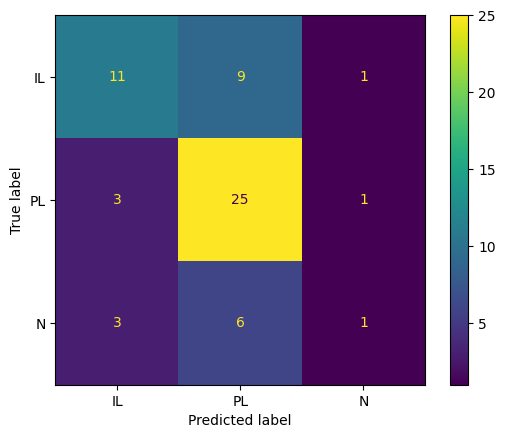

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ['IL', 'PL', 'N']
# _ = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, display_labels=labels)
_ = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, display_labels=labels)

##### Prepare Data for Analysis

In [35]:
channels_filenames = [
            ('bbc', ['bbc_1', 'bbc_2']),
            ('cnn_brasil', ['cnn_brasil_1', 'cnn_brasil_2']),
            ('dw_deutsch', ['dw_deutsch_1']),
            ('france_24', ['france24_1', 'france24_2', 'france24_3']),
            ('nbc', ['nbc_1', 'nbc_2', 'nbc_3']),
            ('trt_word', ['trt_word_1']),
            ('zdf', ['zdf_1', 'zdf_2', 'zdf_3'])       
             ]

In [36]:
import json


# for each filenames group, create a dataframe, and save it
channel_df = pd.DataFrame()
channel_name, filenames = channels_filenames[0] # modify index after each run
for filename in filenames:
    df = pd.read_excel(f'data/raw-data/{filename}.xlsx', engine='openpyxl')
    
    with open(f'data/metadata/{filename}.xlsx.json') as file:
        metadata = json.load(file)
        df['channel'] = metadata['channel name']
        df['country'] = metadata['country']
        df['comment'] = df['comment'].astype(str).apply(clean_comment)
    
    channel_df = pd.concat([channel_df, df], ignore_index=True)

channel_df.dropna(subset=["comment"], inplace=True)
channel_df.to_csv(f'data/transformed-data/{channel_name}.csv', index=False)

ConnectionError: HTTPSConnectionPool(host='api.cognitive.microsofttranslator.com', port=443): Max retries exceeded with url: /translate?api-version=3.0&to=en (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000024EECFE9270>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [28]:
channel_df.shape

(400, 6)

In [ ]:
channel_df.to_csv('data/transformed-data/bbc.csv')

In [ ]:
import os
import json
import pandas as pd

dataframes = []
for i, filename in enumerate(os.listdir('data/metadata/')):
    excel_filename = filename[:-5]
    df = pd.read_excel(f'data/raw-data/{excel_filename}', engine='openpyxl')
    with open(f'data/metadata/{filename}') as file:
        metadata = json.load(file)
        df['channel'] = metadata['channel name']
        df['country'] = metadata['country']
        # df['comment'] = df['comment'].astype(str).apply(clean_comment)
        # df.to_csv(f'data/transformed-data/{i+1}-{filename[:-10]}.csv', index=False)
        dataframes.append(df)

In [ ]:
dfs = pd.concat(dataframes, ignore_index=True, axis=0)
dfs = dfs[['author', 'comment', 'voteCount', 'replyCount', 'channel', 'country']]
dfs.to_csv('data/raw-data/all.csv', encoding='utf-8')
print(f"number of users: {len(dfs['author'].drop_duplicates())}")

In [ ]:
df = pd.read_csv('data/transformed-data/bbc_2.csv')
df['comment'] = df['comment'].astype(str).apply(clean_comment)

In [ ]:
df.to_csv('data/transformed-data/2-bbc_2.csv')

In [ ]:
df

In [ ]:
concatenated = pd.concat([dataframes[0], dataframes[1], dataframes[8],
                          dataframes[9], dataframes[10], dataframes[11]], ignore_index=True, axis=0)
concatenated = concatenated[['author', 'comment', 'voteCount', 'replyCount', 'channel', 'country']]

In [ ]:
# concatenated['class'] = concatenated['comment'].apply(grid_search.predict)
predictions = grid_search.predict(concatenated['comment'].fillna(''))
concatenated['class'] = predictions
# concatenated.to_csv('data/transformed-data/0-training.csv', index=False)

In [ ]:
df_result = pd.read_csv('data/transformed-data/0-training.csv')

In [ ]:
%pip install seaborn

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = ["#0392ff", "#fc0313", "#3d2f2f"]
# custom_palette = sns.color_palette("Set1")

# Assuming 'class' is the column with three classes and 'channel' is the column you want to plot
sns.countplot(x='channel', hue='class', data=df_result, palette=custom_palette)
plt.title('Political Attitudes based on Channels')
plt.show()


##### TOP 10 Voted Comments

In [ ]:
df_result.sort_values('voteCount', ascending=False)[:10]

In [ ]:
df_result.sort_values('replyCount', ascending=False)[:10]